<a href="https://colab.research.google.com/github/JuliaKoryukova/Neural-Networks/blob/main/08_%D0%A2%D1%80%D0%B0%D0%BD%D1%81%D1%84%D0%BE%D1%80%D0%BC%D0%B5%D1%80%D1%8B_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font color='green' size='7'>**Обработка естественного языка. Трансформеры. BERT**</font>  
<font color='#11a642' size='6'>**Использование предварительно обученной модели BERT для классификации текста**</font>   




**Описание плана работы**

1. Загрузка набора данных новостей по темам. Датасет содержит метку раздела новости, текст новости https://huggingface.co/datasets/data-silence/rus_news_classifier
2. Выбор из набора двух классов новостей для задачи классификации.
3. Очистка данных: убрать пунктуацию и стоп-слова. Приведение текста к нижнему регистру. Замена пробелов символом “_”.
4. Использование библиотеки transformers и модель Hugging Face для загрузки предварительно обученной модели BERT и токенизатора. Выбор обученной модели с сайта hugging face https://huggingface.co/models?sort=trending&search=ru+bert
5. Подготовка данных: использование токенизатора BERT для преобразования текстовых данных в формат, который можно подать на вход модели BERT.
6. Создание классификатора на основе BERT: модель BERT с одним линейным слоем для классификации.
7. Обучение классификатора на тренировочных данных
8. Оценка классификатора на данных для тестирования.




# <font color='#11a642' size='6'> Импорт и установка библиотек

In [ ]:
# установка дополнительной библиотеки
!pip install transformers

In [ ]:
!pip -q install pymorphy2

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 800.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 20.5 MB/s eta 0:00:00


In [ ]:
# установка дополнительной библиотеки
!pip install pymorphy3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 31.1 MB/s eta 0:00:00


In [ ]:
!pip install datasets

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 4.1 MB/s eta 0:00:00


In [ ]:
import os # библиотеки работы с папками и системой

# и другие уже известные нам библиотеки
import pandas as pd # табличное представление и чтение|запись csv
import numpy as np # векторы, матрицы
import random # случайный генератор
import time # измерение времени

import re # регулярные выражения: предобработка текстов, строить признаки-шаблоны на слова и подстроки текста и многое другое
import string # работа со строками (в тч пунктуация)

import pymorphy2
import pymorphy3 # Для русского языка
# предобработка текста
import nltk
from nltk.corpus import stopwords # стоп-слова

from sklearn.model_selection import train_test_split # разделение на тестовую и тренировочную выборки
import re # удаление знаков препинания через регулярное выражение

# нейронные слои
import torch
import torch.nn as nn # настройка нейросети (класс родитель)
import torch.optim as optim # оптимизация
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler, random_split # объекты настройки
import torch.nn.functional as F # функция softmax

# трансформеры, предобученные
from transformers import pipeline # высокоуровневая загрузка модели
from transformers import BertModel # класс модели BERT
from transformers import AdamW, get_linear_schedule_with_warmup # оптимизатор и загрузчик
from transformers import BertTokenizer, BertForSequenceClassification # Токенизатор, классификатор

from sklearn.metrics import accuracy_score, roc_curve, auc # метрики классификации
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

import matplotlib
import matplotlib.pyplot as plt # визуализация данных
import seaborn as sns

from datasets import load_dataset
from tqdm import tqdm
from IPython.display import clear_output

In [ ]:
morph = pymorphy3.MorphAnalyzer() # Создать экземпляр Морфологического анализатора для русского языка

In [ ]:
nltk.download('stopwords') # стоп-слова
nltk.download('punkt') # пунктуация

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
plt.rcParams["figure.figsize"] = (10,5) # размер графиков

# <font color='#11a642' size='6'> Загрузка данных
Загрузка набора данных новостей по темам (тренировочную и тестовую выборки). Датасет содержит метку раздела новости, текст новости https://huggingface.co/datasets/data-silence/rus_news_classifier



In [ ]:
# ниже примерный код для загрузки типа файла parquet
#train_news = pd.read_parquet('/content/train-00000-of-00001.parquet')

In [ ]:
# Загрузка набора данных
train_news = load_dataset('data-silence/rus_news_classifier', split='train')
test_news = load_dataset("data-silence/rus_news_classifier", split="test")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/69.1M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/17.3M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/57530 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/14383 [00:00<?, ? examples/s]

In [ ]:
print(train_news[0])

{'news': 'Житель Москвы сходил на сеанс эротического массажа, после которого умер. Об этом сообщает Telegram-канал Mash. По информации издания, 31-летний москвич заказывал сеанс массажа с последующими интимными услугами в квартире на бульваре Яна Райниса. Через некоторое время тело мужчины обнаружили в ванной. Жители дома рассказали полиции, что квартира сдавалась посуточно, и в ней регулярно проходили не только аналогичные сеансы, но и вечеринки, сообщает канал. Точную причину смерти москвича определят следователи. Ранее трое жителей Чечни, чьи личности не раскрываются, пропали после оргии в Грозном. Во время вечеринки компания из четырех человек активно снимала видео, в том числе процесс употребления неизвестного порошка.', 'labels': 1}


In [ ]:
df_train_news = train_news.to_pandas()
df_test_news = test_news.to_pandas()
df_train_news.head()

,news,labels
0,Житель Москвы сходил на сеанс эротического мас...,1
1,В 2021 году Microsoft выпустит специальную вер...,7
2,Министерство культуры и информационной политик...,2
3,Британский боксер-тяжеловес Тайсон Фьюри оскор...,9
4,Растущая напряженность между Индией и Китаем в...,1


In [ ]:
# Названия меток
categories_translator = {
    0 : 'climate',
    1: 'conflicts',
    2: 'culture',
    3: 'economy',
    4: 'gloss',
    5: 'health',
    6: 'politics',
    7: 'science',
    8: 'society',
    9: 'sports',
    10: 'travel'}

## <font color='#11a642' size='5'> Работа с текстом
Выбор из набора два класса новостей для задачи классификации.


In [ ]:
# Узнать количество уникальных меток
num_labels = df_train_news['labels'].nunique()
num_labels

11

In [ ]:
# Количество новостей в каждой метке
label_counts = df_train_news['labels'].value_counts()
label_counts

,count
labels,
4,7993
1,6277
3,5636
6,5558
7,5406
8,4937
5,4931
9,4791
2,4573


In [ ]:
# Выбираю два класса новостей для задачи классификации - 0 и 10
df_train_news['label_name'] = df_train_news['labels'].apply(lambda x: categories_translator[x])
df_train_news

,news,labels,label_name
0,Житель Москвы сходил на сеанс эротического мас...,1,conflicts
1,В 2021 году Microsoft выпустит специальную вер...,7,science
2,Министерство культуры и информационной политик...,2,culture
3,Британский боксер-тяжеловес Тайсон Фьюри оскор...,9,sports
4,Растущая напряженность между Индией и Китаем в...,1,conflicts
...,...,...,...
57525,"Популярные парки аттракционов, закрытые на год...",10,travel
57526,Модный редактор Vogue Хенрик Лишке назвал солн...,4,gloss
57527,Партнерам следует тщательнее подбирать слова и...,5,health
57528,44-летняя полная женщина повторила откровенные...,4,gloss


In [ ]:
filter_train = df_train_news[df_train_news['labels'].isin([0, 10])]

# Заменяем метку 10 на 1
filter_train['labels'] = filter_train['labels'].replace({10: 1})
filter_train.head()

<ipython-input-16-6739f3d09f42>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filter_train['labels'] = filter_train['labels'].replace({10: 1})


,news,labels,label_name
11,Бывшая стюардесса американских авиалиний возму...,1,travel
12,"Российские пожарные спасли детеныша косули, по...",0,climate
13,"Российская туристка, отдохнувшая в Армении, оп...",1,travel
32,Житель Сахалина заметил на острове орлана — кр...,0,climate
37,Российские заводы начнут работать по-новому ра...,0,climate


/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


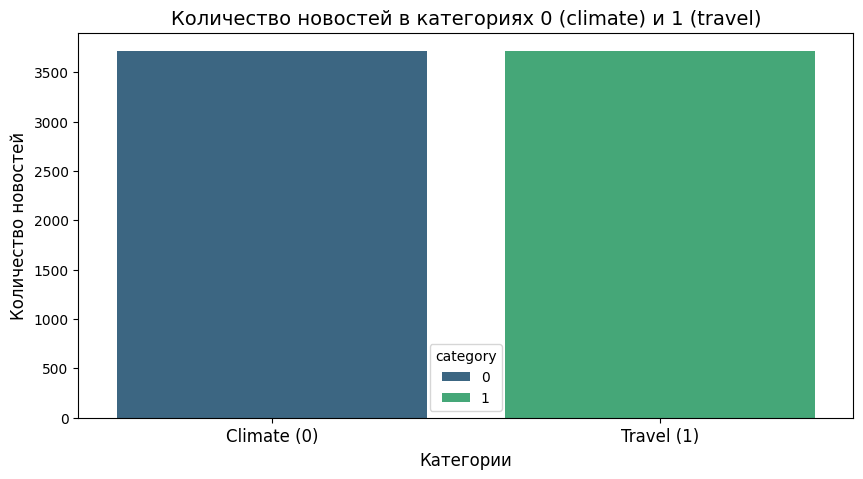

In [ ]:
# График количества новостей в этих двух категориях

# Количество новостей в каждой категории
label_counts_filter = filter_train['labels'].value_counts()

# Создание DataFrame для использования в Seaborn
label_count_filter_df = label_counts_filter.reset_index()
label_count_filter_df.columns = ['category', 'count']

# Построение графика
sns.barplot(x='category', y='count', data=label_count_filter_df, palette='viridis', hue='category')

plt.title('Количество новостей в категориях 0 (climate) и 1 (travel)', fontsize=14)
plt.xlabel('Категории', fontsize=12)
plt.ylabel('Количество новостей', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['Climate (0)', 'Travel (1)'], fontsize=12)
plt.show()

In [ ]:
print(filter_train.shape)
print(filter_train[filter_train['label_name']=='climate'].shape)
print(filter_train[filter_train['label_name']=='travel'].shape)

(7428, 3)
(3712, 3)
(3716, 3)


Вывод:

После фильтрации по меткам 0 (climate) и 10 (travel) итоговый набор данных содержит 7428 записей.

Данные в обеиз категориях распределены почти равномерно, что положительно скажется на задаче классификации и предсказательной способности, так как модель не будет сталкиваться с дисбалансом классов.

## <font color='#11a642' size='5'> Препроцессинг
Очистка данных: убрать пунктуацию и стоп-слова. Приведение текста к нижнему регистру.



In [ ]:
# Очистка текста от пунктуации, чисел, стоп-слов и приведение к нижнему регистру

# стоп-слова
nltk.download('stopwords')

# лемматизатор pymorphy2, natasha
morph = pymorphy2.MorphAnalyzer()

# Cписок стоп-слов
stopWords = set(nltk.corpus.stopwords.words('russian'))

# удаление пунктуации
SYMBOLS = " ".join(string.punctuation).split(" ") + ["-", "...", "”", "”"]

def str_preprocess(text: str)->list:
    """
    Очистка текста
    """
    reg = re.compile('[^а-яА-яa-zA-Z0-9 ]') # буквы русского, английского, числа
    text = text.lower().replace("ё", "е") # ё замена на е - с осторожностью, чат
    text = text.replace("ъ", "ь") # замена ь  - с осторожностью, чат
    text = text.replace("й", "и") # замена й  - с осторожностью, чат
    text = text.replace("\\n", "") # замена переноса строки
    text = text.replace("\\r", "") # замена спецсимволов
    text = text.replace("\\t", "") # замена длинных табов
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'сайт', text) # url
    #text = re.sub('@[^\s]+', 'пользователь', text) # пользователь s - строка
    text = reg.sub(' ', text) # удаление символов

    # Лемматизация
    text =  " ".join([word for word in text.split() if word not in SYMBOLS]) # фильтр символов
    text =[morph.parse(word)[0].normal_form for word in text.split() if word not in stopWords] # фильтр стоп-слов
    return ' '.join(text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
tqdm.pandas()

# применяем очистку текста
filter_train = filter_train.copy()
filter_train['clean_text'] = filter_train['news'].progress_apply(lambda x: str_preprocess(x))

filter_train.head()

100%|██████████| 7428/7428 [03:04<00:00, 40.16it/s]


,news,labels,label_name,clean_text
11,Бывшая стюардесса американских авиалиний возму...,1,travel,бывший стюардесса американский авиалиния возму...
12,"Российские пожарные спасли детеныша косули, по...",0,climate,россииский пожарный спасти детёныш косуля попа...
13,"Российская туристка, отдохнувшая в Армении, оп...",1,travel,россииский туристка отдохнуть армения описать ...
32,Житель Сахалина заметил на острове орлана — кр...,0,climate,житель сахалин заметить остров орлан крупный х...
37,Российские заводы начнут работать по-новому ра...,0,climate,россииский завод начать работать новый ради сп...


# <font color='#11a642' size='6'> Работа с BERT

## <font color='#11a642' size='5'> Загрузка модели
Использование библиотеки transformers и модель Hugging Face для загрузки предварительно обученной модели BERT и токенизатора. Выбор обученной модели с сайта hugging face https://huggingface.co/models?sort=trending&search=ru+bert




In [ ]:
# Загрузка токенизаторов и модели
model_name = 'DeepPavlov/rubert-base-cased'
tokenizer = BertTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Краткое описание модели:

RuBERT (язык русский, обрезанная, 12-слойная, 768 скрытых, 12 голов, 180 М параметров) была обучена на русской части Википедии и новостных данных. Были использованы эти обучающие данные для создания словаря русских субтопонимов и взята многоязычная версия BERT-base в качестве инициализации для RuBERT

# <font color='#11a642' size='5'>Подготовка данных
Использование токенизатора BERT для преобразования текстовых данных в формат, который можно подать на вход модели BERT.


In [ ]:
# Подсчет максимальной длины предложения в датасете
max_calc_len = 0
for sent in filter_train:
    input_ids = tokenizer.encode(sent, add_special_tokens=True)
    max_calc_len = max(max_calc_len, len(input_ids))

print(f'Максимальная длина токенизированного текста: {max_calc_len}')

Максимальная длина токенизированного текста: 7


In [ ]:
# Кодирование текста для подачи в модель
%%time

# Определяю колонку с текстом, которую буду использовать в токенизаторе
texts = filter_train['clean_text'].tolist() # Преобразую в список
labels = filter_train['labels'].tolist()  # Преобразую метки в список

# максимальная длина текста в токенах
max_length = 15

# списки для индексов токенов, масок внимания и тагрет индексов категорий текста
input_ids = []
attention_masks = []
target_ids = []

# Токенизация текстов
tokens = tokenizer(texts,
                   add_special_tokens=True, # добавить '[CLS]' и '[SEP]' токены
                   padding=True, # добавляю паддинг до максимальной длины
                   truncation=True, # обрезаю тексты, превышающие максимальную длину
                   max_length=max_length,
                   return_attention_mask=True,  # делать ли маску внимания
                   return_tensors='pt') # возвращаю тензоры


# Преобразование меток в тензоры
target_ids = torch.tensor(labels)

# Получение токенов и маски внимания
input_ids = tokens['input_ids']
attention_masks = tokens['attention_mask']


# Вывод формы токенов и маски внимания
print("Input IDs Shape:", input_ids.shape)            # Форма input_ids
print("Attention Mask Shape:", attention_masks.shape)  # Форма attention_mask
print("Target IDs Shape:", target_ids.shape)          # Форма меток

Input IDs Shape: torch.Size([7428, 15])
Attention Mask Shape: torch.Size([7428, 15])
Target IDs Shape: torch.Size([7428])
CPU times: user 30.1 s, sys: 89.7 ms, total: 30.2 s
Wall time: 34.2 s


In [ ]:
# Инициализация датасета
# датасет из тензоров
dataset = TensorDataset(input_ids, attention_masks, target_ids)

# разделение на датасеты для обучения и валидации
val_size = 0.2
train_dataset, val_dataset = random_split(dataset, [1 - val_size, val_size])

# кол-во предложений в каждом датасете
len(train_dataset), len(val_dataset)

(5943, 1485)

In [ ]:
# Инициализация даталоадера
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Проверка работы лоадера
input_ids, attention_mask, target_ids = next(iter(train_loader))
input_ids.shape, attention_mask.shape, target_ids.shape

(torch.Size([32, 15]), torch.Size([32, 15]), torch.Size([32]))

Вывод:

Максимальная длина текста 7 токенов, поэтому в токенизаторе установлено ограничение в 15 токенов.

Набор разделен на обучающую и валидационную выборку.

Для каждого батча используется 32 текста по 15 токенов.

# <font color='#11a642' size='5'>Работа с классификатором
Создание классификатора на основе BERT: модель BERT с одним линейным слоем для классификации.


In [ ]:
# Инициализация модели
model_name = 'DeepPavlov/rubert-base-cased'
num_labels = 2
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

# оптимизатор
LR = 0.000_02
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

# кол-во эпох обучения
EPOCHS = 10
# расчет общего кол-ва шагов обучения для шедулера
total_steps = len(train_loader) * EPOCHS

# инициализация планировщика - шедулера
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=len(train_loader) * total_steps)

# функция ошибки
loss_fn = torch.nn.CrossEntropyLoss()
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(DEVICE)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Архитектура модели
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

# <font color='#11a642' size='5'>Тренировка классификатора
Обучение классификатора на тренировочных данных.


In [ ]:
!export CUDA_LAUNCH_BLOCKING=1

In [ ]:
!export TORCH_USE_CUDA_DSA

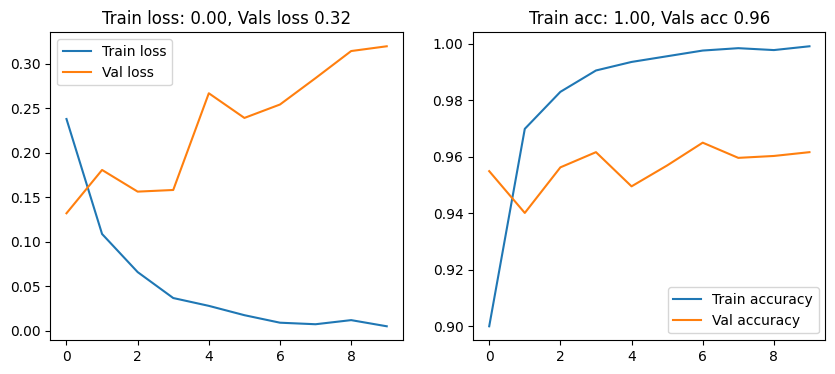

CPU times: user 4min 33s, sys: 2.37 s, total: 4min 36s
Wall time: 4min 44s


In [ ]:
%%time

train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(EPOCHS):
    # ========================= TRAIN ===============================
    model.train()

    correct_predictions = 0
    epoch_loss = 0

    for input_ids, attention_mask, targets in tqdm(train_loader, desc='Training', leave=False):
        # переместить все тензоры на девайс
        input_ids = input_ids.to(DEVICE)
        attention_mask = attention_mask.to(DEVICE)
        targets = targets.to(DEVICE)

        # передать в модель индексы токенов и макси внимания
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        # расчет ошибки
        loss = loss_fn(outputs.logits, targets)
        epoch_loss += loss.item()

        # получение ответов модели для расчета accuracy и расчет accuracy
        preds = torch.argmax(outputs.logits, dim=1)
        correct_predictions += torch.sum(preds == targets).item()

        # обучение модели
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    # нормировка ошибки accuracy
    train_loss = epoch_loss / len(train_loader)
    train_acc = correct_predictions / len(train_loader.dataset)

    train_losses.append(train_loss)
    train_accs.append(train_acc)


    # ==================== VALIDATION ============================
    model.eval()

    correct_predictions = 0
    epoch_loss = 0

    for input_ids, attention_mask, targets in tqdm(val_loader, desc='Validation', leave=False):
        input_ids = input_ids.to(DEVICE)
        attention_mask = attention_mask.to(DEVICE)
        targets = targets.to(DEVICE)

        with torch.inference_mode():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        preds = torch.argmax(outputs.logits, dim=1)
        loss = loss_fn(outputs.logits, targets)

        epoch_loss += loss.item()
        correct_predictions += torch.sum(preds == targets).item()

    val_loss = epoch_loss / len(val_loader)
    val_acc = correct_predictions / len(val_loader.dataset)

    val_losses.append(val_loss)
    val_accs.append(val_acc)


    # ================ PLOT METRICS ===================================
    clear_output(True)
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.title(f'Train loss: {train_losses[-1]:.2f}, Vals loss {val_losses[-1]:.2f}')
    plt.plot(train_losses, label='Train loss')
    plt.plot(val_losses, label='Val loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.title(f'Train acc: {train_accs[-1]:.2f}, Vals acc {val_accs[-1]:.2f}')
    plt.plot(train_accs, label='Train accuracy')
    plt.plot(val_accs, label='Val accuracy')
    plt.legend()

    plt.show()

# <font color='#11a642' size='5'>Оценка качества
Оценка результата на данных для тестирования.


In [ ]:
# Применение предобработки к тестовому набору данных
test_news_df = test_news.to_pandas()

# Фильтрация данных - оставляем только классы climate (0) и travel (1)
filtered_test_news_df = test_news_df[test_news_df['labels'].isin([0, 1])]

# Создание копии отфильтрованного DataFrame
filtered_test_news_df = filtered_test_news_df.copy()

# Применение предобработки
filtered_test_news_df['clean_text'] = filtered_test_news_df['news'].apply(lambda x: str_preprocess(x))

# Токенизация текстов в тестовом наборе данных
max_length = 15
test_encodings = tokenizer(
    filtered_test_news_df['clean_text'].tolist(),
    truncation=True,
    padding=True,
    max_length=max_length,
    return_tensors='pt'
)

# Подготовка целевых меток
test_labels = torch.tensor(filtered_test_news_df['labels'].tolist())

# Создание TensorDataset
test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], test_labels)

# Создание DataLoader для тестового набора данных
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)  # shuffle=False для тестовых данных

In [ ]:
# Оценка модели
model.eval()  # модель в режиме оценки
predictions, true_labels = [], []

with torch.inference_mode():
    for input_ids, attention_mask, targets in tqdm(test_loader, desc='Testing', leave=False):
        input_ids = input_ids.to(DEVICE)
        attention_mask = attention_mask.to(DEVICE)
        targets = targets.to(DEVICE)

        # Прогнозируем
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)

        # Сохраняем предсказания и истинные метки
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(targets.cpu().numpy())

# Подсчет метрик
accuracy = accuracy_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions, average='weighted')  # Подсчет F1-score с учетом весов
precision = precision_score(true_labels, predictions, average='weighted', zero_division=0)  # Подсчет Precision
recall = recall_score(true_labels, predictions, average='weighted', zero_division=0)  # Подсчет Recall

# Создаем отображение индексов на классы
INDEX_TO_CLASS = {
    0: 'climate',
    1: 'travel',
}

# Получаем уникальные метки
unique_labels = sorted(set(true_labels) | set(predictions))

# Фильтруем уникальные метки, чтобы оставить только те, которые есть в INDEX_TO_CLASS
filtered_labels = [label for label in unique_labels if label in INDEX_TO_CLASS]

# Создаем target_names на основе отфильтрованных меток
target_names = [INDEX_TO_CLASS[label] for label in unique_labels if label in INDEX_TO_CLASS]

# Генерация отчета с правильными метками
report = classification_report(true_labels, predictions, target_names=target_names, labels=unique_labels)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print("Classification Report:")
print(report)

Accuracy: 0.7583
F1 Score: 0.7585
Precision: 0.8323
Recall: 0.7583
Classification Report:
              precision    recall  f1-score   support

     climate       0.62      0.97      0.76       976
      travel       0.97      0.63      0.76      1523

    accuracy                           0.76      2499
   macro avg       0.79      0.80      0.76      2499
weighted avg       0.83      0.76      0.76      2499



In [ ]:
@torch.inference_mode()
def predict_text(model, text):
    # Проверка на пустой ввод
    if not text:
        print("Ошибка: Входной текст пуст.")
        return

    # Кодирование текста
    encoded_dict = tokenizer(
        text,
        add_special_tokens=True,
        truncation=True,
        padding='max_length',
        max_length=512,
        return_attention_mask=True,
        return_tensors='pt',
    )

    # Перемещение тензоров на устройство
    encoded_dict = {key: value.to(DEVICE) for key, value in encoded_dict.items()}

    # Получение предсказаний
    outputs = model(**encoded_dict)
    pred_token_id = outputs.logits.argmax(-1).item()  # Получение ID класса
    predicted_class = INDEX_TO_CLASS[pred_token_id]  # Получение имени класса

    # Форматированный вывод
    print(f'Класс текста: {predicted_class} (ID: {pred_token_id})')

In [ ]:
# перевести модель в режим оценки
model.eval();

In [ ]:
text_sample = "Изменение климата приводит к увеличению частоты экстремальных погодных явлений, таких как наводнения и засухи."
predict_text(model, text_sample)

Класс текста: climate (ID: 0)


In [ ]:
text_sample = "Путешествия открывают новые горизонты, позволяя знакомиться с культурами и традициями разных стран."
predict_text(model, text_sample)

Класс текста: travel (ID: 1)


In [ ]:
text_sample = "На Солнце произошла вспышка максимального класса."
predict_text(model, text_sample)

Класс текста: climate (ID: 0)


Вывод:

Результаты показывают, что модель демонстрирует хорошие результаты на тестовом наборе данных, классифицируя тексты на темы "climate" и "travel". Вот ключевые выводы:

Accuracy (Точность): 75.83% — это процент верно предсказанных меток для всего тестового набора.

F1 Score: 75.85% — почти идентичен точности, что говорит о сбалансированной модели.

Precision (Точность): 83.23% — это процент правильно предсказанных положительных меток по отношению ко всем предсказанным как положительные. Высокая точность для класса "travel" показывает, что модель точно предсказывает этот класс.

Recall (Полнота): 75.83% — это процент правильно предсказанных положительных меток по отношению ко всем реальным положительным примерам. Модель лучше справляется с классом "climate" (97% полноты), чем с "travel" (63%).




Общий вывод:

Модель BERT была использована для классификации новостей, и результаты показали высокую точность.
